In [3]:
from fastai.tabular.all import *
import numpy as np

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Read the csv file into a dataframe

In [4]:
cwd = os.getcwd()
parent = os.path.dirname(cwd)
csv_path = os.path.join(parent, "data/", "master_results.csv")

In [5]:
df = pd.read_csv(csv_path, low_memory=False)
df.head(3)

,p_in,Re,Geometry
0,11.922400,532.38,channelStripRe
1,12.093420,760.11,channelStripRe
2,6.648019,1898.78,leftStripBendRe


In [6]:
df.Geometry = df.Geometry.transform(lambda x: x[:-2])

Let's look at the pressure column

In [7]:
df['p_in'].describe()

count    6.400000e+02
mean     9.761427e+20
std      2.469467e+22
min      2.455772e-01
25%      9.476800e-01
50%      2.528182e+00
75%      7.338899e+00
max      6.247313e+23
Name: p_in, dtype: float64

From the values above we can see that some of the flow cases have not been solved properly by openFOAM. Let's drop all of the unnatural values.

In [8]:
df['p_in'] = np.where(df['p_in'] > 100, False, df['p_in'])
labels = df['p_in'] != False
df = df.loc[labels, :]
df.shape

(625, 3)

In [9]:
df['p_in'].describe()

count    625.000000
mean       5.198978
std        8.167323
min        0.245577
25%        0.926666
50%        2.519571
75%        6.740670
max       88.850320
Name: p_in, dtype: float64

In [10]:
df['p_in'] = np.log1p(df['p_in'])

In [11]:
procs = [Categorify,  Normalize]
cat = "Geometry"
cont = "Re"
dep_var = "p_in"

We will randomly split the dataset into a training and validation sets.

In [12]:
splits = RandomSplitter()(df)
tabular_set = TabularPandas(
    df=df,
    procs=procs,
    cat_names=cat,
    cont_names=cont,
    y_names=dep_var,
    y_block=RegressionBlock(),
    splits=splits
)

In [13]:
# Create DataLoaders
dls = tabular_set.dataloaders(bs=16)  # Batch size 64

In [14]:
learn = tabular_learner(
    dls, 
    layers=[50, 25],  
    metrics=mae)

Let's check the embeddings

In [15]:
list(learn.model.embeds.named_children())

[('0', Embedding(9, 5))]

Find the optimal learning rate

SuggestedLRs(valley=0.02754228748381138)

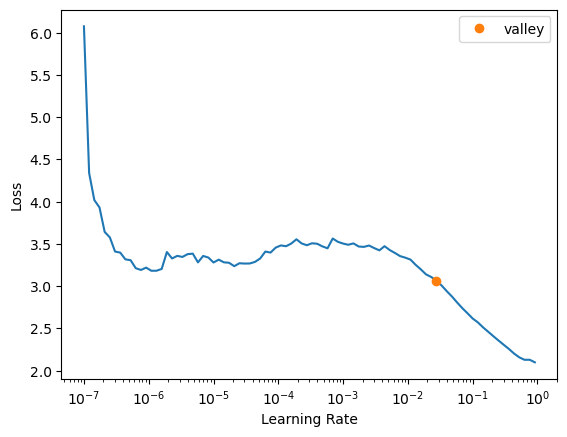

In [88]:
learn.lr_find()

In [16]:
# Train for a few epochs
learn.fit(10, lr=0.01)  # Very small LR to test

epoch,train_loss,valid_loss,mae,time
0,1.362419,0.333272,0.501161,00:00
1,0.608850,0.058073,0.190223,00:00
2,0.374528,0.130924,0.285460,00:00
3,0.287302,0.041336,0.155080,00:00
4,0.220367,0.033219,0.154002,00:00
5,0.190571,0.090499,0.226653,00:00
6,0.176006,0.042688,0.153758,00:00
7,0.168732,0.053521,0.170398,00:00
8,0.162196,0.023462,0.115532,00:00
9,0.147785,0.034820,0.155220,00:00


In [17]:
preds, targets = learn.get_preds(dl=dls.valid)


In [18]:
preds = preds.numpy().flatten()
targets = targets.numpy().flatten()

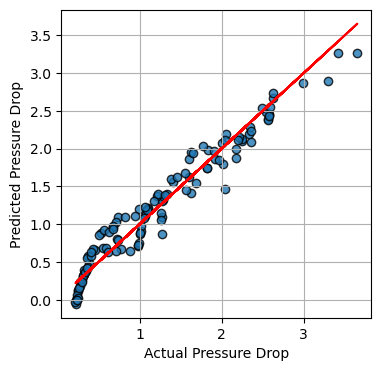

In [19]:
plt.figure(figsize=(4,4))
plt.scatter(targets, preds, alpha=0.8, edgecolors='black')
plt.plot(targets, targets, color='red')
plt.xlabel("Actual Pressure Drop")
plt.ylabel("Predicted Pressure Drop")
plt.grid()
plt.show()

In [27]:
# Get embedding layers
def get_embeddings(learn, cat_var_name):
    """Extract embeddings for a specific categorical variable"""
    # Find the embedding layer for this variable
    emb_layer = None
    for name, layer in learn.model.embeds.named_children():
        if name == cat_var_name:
            emb_layer = layer
            break
    
    if emb_layer is None:
        print(f"Embedding layer for {cat_var_name} not found")
        return None
    
    # Extract weights (embedding matrix)
    embeddings = emb_layer.weight.data.cpu().numpy()
    return embeddings

# Example usage
embeddings = get_embeddings(learn, '0')

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [29]:
dls.classes['Geometry']

['#na#', 'backwardStep', 'bend', 'channel', 'channelStrip', 'forwardStep', 'leftStripBend', 'narrowEndBend', 'rightStripBend']

In [30]:
reducer = PCA(n_components=2)

In [32]:
embeddings_2d = reducer.fit_transform(embeddings)
embeddings_2d

array([[-0.01096117, -0.0292684 ],
       [ 0.26984605,  0.0716204 ],
       [ 0.25961563, -0.25794834],
       [ 0.383821  ,  0.01167192],
       [-0.3532307 , -0.35975066],
       [ 0.02596125,  0.12041295],
       [-0.30559364,  0.09989823],
       [-0.01240322,  0.12847203],
       [-0.25705528,  0.21489188]], dtype=float32)

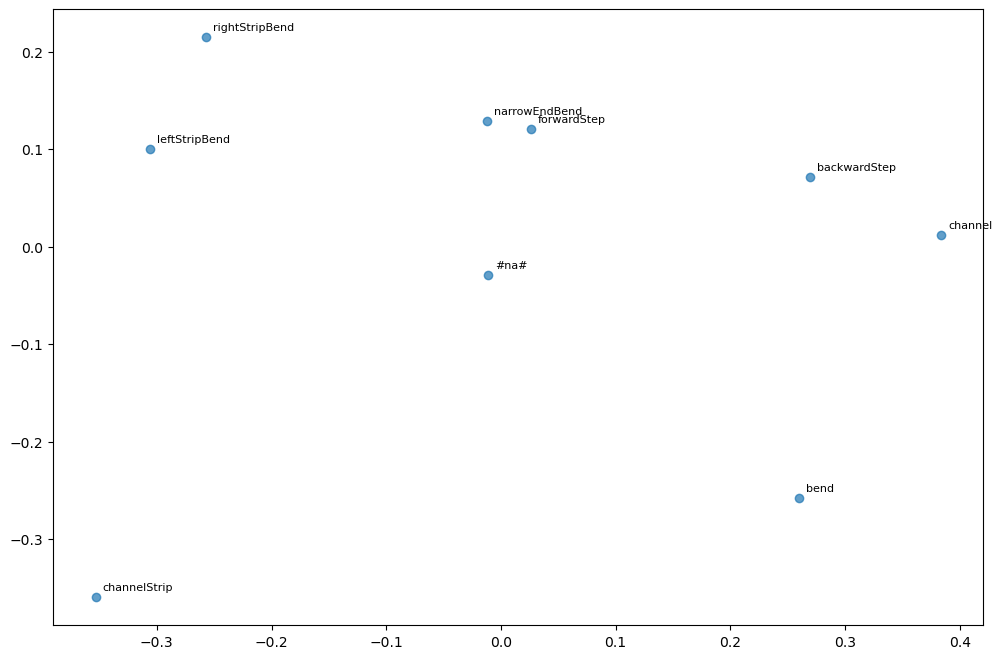

In [33]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
# Add labels for some points
for i, (x, y) in enumerate(embeddings_2d):
    plt.annotate(dls.classes['Geometry'][i], (x, y), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)

In [34]:
save_pickle('models/baselineModel.pkl', learn)